In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/test/8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2100032a-7c33-4bff-97ef-690822c43466.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2f392438-e215-4169-bebf-21ac4ff253e1.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/3f316b38-1a24-45a9-8d8c-4e05a42257c6.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/f8b03c87-9d1a-4f20-b76b-cb6c69d447b2.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/585ba241-6348-41ce-a5d2-c9ee434cd64d.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/bde73ad6-ce46-489b-8ee0-b162698cc6df.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/c7ce1ac6-36e4-4258-b2e4-1b525dc82ad5.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/9d75e205-3030-44c6-ae

# Libraries

In [6]:
import pandas as pd
import numpy as np
import random
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import re
import json
from tqdm.autonotebook import tqdm
import string
import itertools

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import utils
from keras.models import *
from keras.layers import *
from keras.callbacks import *

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

In [7]:
#define stopwords
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

# OBTAIN

In [8]:
#read train data
train_df = pd.read_csv('../input/flatiron-capstone-project/train_df.csv', index_col = 0)
train_df.head()

Id  \
0  d0fa7568-7d8e-4db9-870f-f9c6f668c17b   
1  2f26f645-3dec-485d-b68d-f013c9e05e60   
2  c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29   
3  5c9a3bc9-41ba-4574-ad71-e25c1442c8af   
4  c754dec7-c5a3-4337-9892-c02158475064   

                                           pub_title  \
0  The Impact of Dual Enrollment on College Degre...   
1  Educational Attainment of High School Dropouts...   
2  Differences in Outcomes for Female and Male St...   
3  Stepping Stone and Option Value in a Model of ...   
4  Parental Effort, School Resources, and Student...   

                           dataset_title  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           dataset_label  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           cleaned_label  \
0  national education longitudinal study   
1  national education longitudinal study   
2  national education longitudinal study   
3  national education longitudinal study   
4  national education longitudinal study   

                                                text  
0  this study used data from the national educati...  
1  dropping out of high school is not necessarily...  
2  stress satisfactory outcomes for all youth inc...  
3  federal reserve bank of richmond s1 accounting...  
4  this article investigates an important factor ...

In [9]:
#read submission data
submission_df = pd.read_csv('../input/flatiron-capstone-project/submission.csv', index_col = 0)
submission_df.head()

Id  PredictionString  \
0  2100032a-7c33-4bff-97ef-690822c43466               NaN   
1  2f392438-e215-4169-bebf-21ac4ff253e1               NaN   
2  3f316b38-1a24-45a9-8d8c-4e05a42257c6               NaN   
3  8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60               NaN   

                                                text  
0  Cognitive deficits and reduced educational ach...  
1  This report describes how the education system...  
2  Cape Hatteras National Seashore (CAHA), locate...  
3  A significant body of research has been conduc...

Now, our job is to fill in the column 'PredictionString' with cleaned_label that matches the given text.

# CLASSIFIERS: RandomForestClassifier, SGDClassifier, MultinomialNB

## Preprocessing

Preprocessing text data is a bit more challenging that working with more traditional data types because there's no clear-cut answer for exactly what sort of preprocessing and cleaning we need to do. Before we can begin cleaning and preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

### Count Vectorization

Machine Learning algorithms don't understand strings. However, they do understand math, which means they understand vectors and matrices. By Vectorizing the text, we just convert the entire text into a vector, where each element in the vector represents a different word. The vector is the length of the entire vocabulary -- usually, every word that occurs in the English language, or at least every word that appears in our corpus. Any given sentence can then be represented as a vector where all the vector is 1 (or some other value) for each time that word appears in the sentence.

### TD-IDF Vectorization

TD-IDF is short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

**Count Vectorizer give number of frequency with respect to index of vocabulary where as tf-idf consider overall documents of weight of words.**

### Train-Test-Split

In [10]:
#define X, y
X = train_df['dataset_title'].to_numpy()
y = train_df['cleaned_label'].to_numpy()

In [11]:
#split traing data into training a validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [12]:
#check shape
print('Train sentences:', X_train.shape, '\n', 
      'Test sentences:', X_test.shape, '\n', 
      'Train labels:', y_train.shape, '\n', 
      'Test labels:', y_test.shape)

Train sentences: (15728,) 
 Test sentences: (3933,) 
 Train labels: (15728,) 
 Test labels: (3933,)


In [13]:
# find avg # of takens (words) in the training set
round(sum([len(i.split()) for i in X_train]) / len(X_train))

5

### Vectorize

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 6)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(X_train, y_train, X_test):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    X_train = vectorizer.fit_transform(X_train)

    # Vectorize validation texts.
    X_test = vectorizer.transform(X_test)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, X_train.shape[1]))
    selector.fit(X_train, y_train)
    X_train = selector.transform(X_train).astype('float32')
    X_test = selector.transform(X_test).astype('float32')
    return X_train, X_test

In [15]:
ngram_vectorize(X_train, y_train, X_test)

(<15728x746 sparse matrix of type '<class 'numpy.float32'>'
 	with 231852 stored elements in Compressed Sparse Row format>,
 <3933x746 sparse matrix of type '<class 'numpy.float32'>'
 	with 57724 stored elements in Compressed Sparse Row format>)

In [16]:
X_train

array(['Education Longitudinal Study',
       'Sea, Lake, and Overland Surges from Hurricanes',
       'Beginning Postsecondary Student', ...,
       'Survey of Doctorate Recipients',
       'North American Breeding Bird Survey (BBS)',
       'Rural-Urban Continuum Codes'], dtype=object)

In [17]:
X_test

array(['Baltimore Longitudinal Study of Aging (BLSA)',
       "Alzheimer's Disease Neuroimaging Initiative (ADNI)",
       'NOAA Tide Gauge', ..., 'National Education Longitudinal Study',
       'Agricultural Resource Management Survey',
       "Alzheimer's Disease Neuroimaging Initiative (ADNI)"], dtype=object)

### Encode Label

In [18]:
#from sklearn import preprocessing

#use the LabelEncoder to convert text labels to integers, 0, 1, 2, etc.
encoder = preprocessing.LabelEncoder()

#since we have two different data set (X_train and X_test), 
#we need to fit it on all of our data otherwise there might be some categories in the test set X_test that were not in the train set X_train 
#and we will get errors
encoder.fit(list(y_train) + list(y_test)) 
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [19]:
encoder.classes_

array(['2019 ncov complete genome sequences', '2019 ncov genome sequence',
       '2019 ncov genome sequences', 'adni',
       'advanced national seismic system anss comprehensive catalog comcat ',
       'advanced national seismic system comprehensive catalog',
       'aging integrated database', 'aging integrated database agid ',
       'agricultural resource management survey',
       'agricultural resources management survey',
       'alzheimer s disease neuroimaging initiative adni ',
       'alzheimers disease neuroimaging initiative',
       'anss comprehensive catalog',
       'anss comprehensive earthquake catalog',
       'arms farm financial and crop production practices',
       'baccalaureate and beyond',
       'baccalaureate and beyond longitudinal study',
       'baltimore longitudinal study of aging',
       'baltimore longitudinal study of aging blsa ',
       'beginning postsecondary student',
       'beginning postsecondary students',
       'beginning postsecondary

### Correct Class Imbalance

In [20]:
#from imblearn.over_sampling import SMOTE

#previous original class distribution
#print('Class Distribution Before:')
#print('Train Set')
#print(y_train.value_counts())

#fit
#smote = SMOTE()
#X_train, y_train = smote.fit_resample(X_train, y_train)

#check class distribution
#print('\n')
#print('Class Distribution After:')
#print('Train Set')
#print(y_train.value_counts())

## Random Forest

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

#create a tokenization a modelling pipeline
RandomForestClassifier_model = Pipeline([('tfidf', TfidfVectorizer(min_df = 3,
                                                                   max_features = None,
                                                                   strip_accents = 'unicode',
                                                                   analyzer = 'word',
                                                                   token_pattern = r'\w{1,}',
                                                                   ngram_range = (1, 3),
                                                                   use_idf = 1,
                                                                   smooth_idf = 1,
                                                                   sublinear_tf = 1,
                                                                   stop_words = stopwords_list)), #convert words to munbers using tfid
                                         ('clf', RandomForestClassifier(n_estimators = 100, random_state = 123))]) #model the text

#fit the pipeline to the training data
RandomForestClassifier_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode', sublinear_tf=1,
                                 token_pattern='\\w{1,}', use_idf=1)),
                ('clf', RandomForestClassifier(random_state=123))])

In [22]:
#predict 
RandomForestClassifier_yhat_train = RandomForestClassifier_model.predict(X_train)
RandomForestClassifier_yhat_test = RandomForestClassifier_model.predict(X_test)

#train accuracy 
RandomForestClassifier_train_accuracy = accuracy_score(y_train, RandomForestClassifier_yhat_train) * 100
print('Train accuracy: {0}'.format(RandomForestClassifier_train_accuracy))

#test accuracy 
RandomForestClassifier_test_accuracy = accuracy_score(y_test, RandomForestClassifier_yhat_test) * 100
print('Test accuracy: {0}'.format(RandomForestClassifier_test_accuracy))

Train accuracy: 74.57400813835199
Test accuracy: 74.57411645054665


In [23]:
from sklearn.model_selection import KFold, cross_val_score

#get cross validation to make sure model has gotten most of the patterns from the data correctly, 
#and its not picking up too much on the noise
k_fold = KFold(n_splits = 5)
RandomForestClassifier_CV = cross_val_score(RandomForestClassifier_model, X_train, y_train, 
                                            cv = k_fold, scoring = 'accuracy', n_jobs=-1).mean()
RandomForestClassifier_CV

0.745167912012832

In [24]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

#get classification report
print('Model: RandomForestClassifier', '\n', classification_report(y_test, RandomForestClassifier_yhat_test))

Model: RandomForestClassifier 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.58      1.00      0.74       709
           4       0.00      0.00      0.00         2
           8       0.94      1.00      0.97       127
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00       487
          11       0.00      0.00      0.00        17
          12       0.40      1.00      0.57         2
          13       0.00      0.00      0.00         1
          15       0.68      1.00      0.81        45
          16       0.00      0.00      0.00        21
          17       0.74      1.00      0.85       248
          18       0.00      0.00      0.00        86
          19       0.00      0.00      0.00        13
          20       0.47      1.00      0.64        47
          21       0.00      0.00      0.00      

In [25]:
#from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    #compute confusion matrix
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90, fontsize = 12)
    plt.yticks(tick_marks, classes, fontsize = 12)

    #loop over data dimensions and create text annotations
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label', fontsize = 25)
    plt.xlabel('Predicted label', fontsize = 25)
    plt.tight_layout()

In [26]:
#generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(5):
    prediction = RandomForestClassifier_model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences



In [27]:
y_softmax = RandomForestClassifier_model.predict(X_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

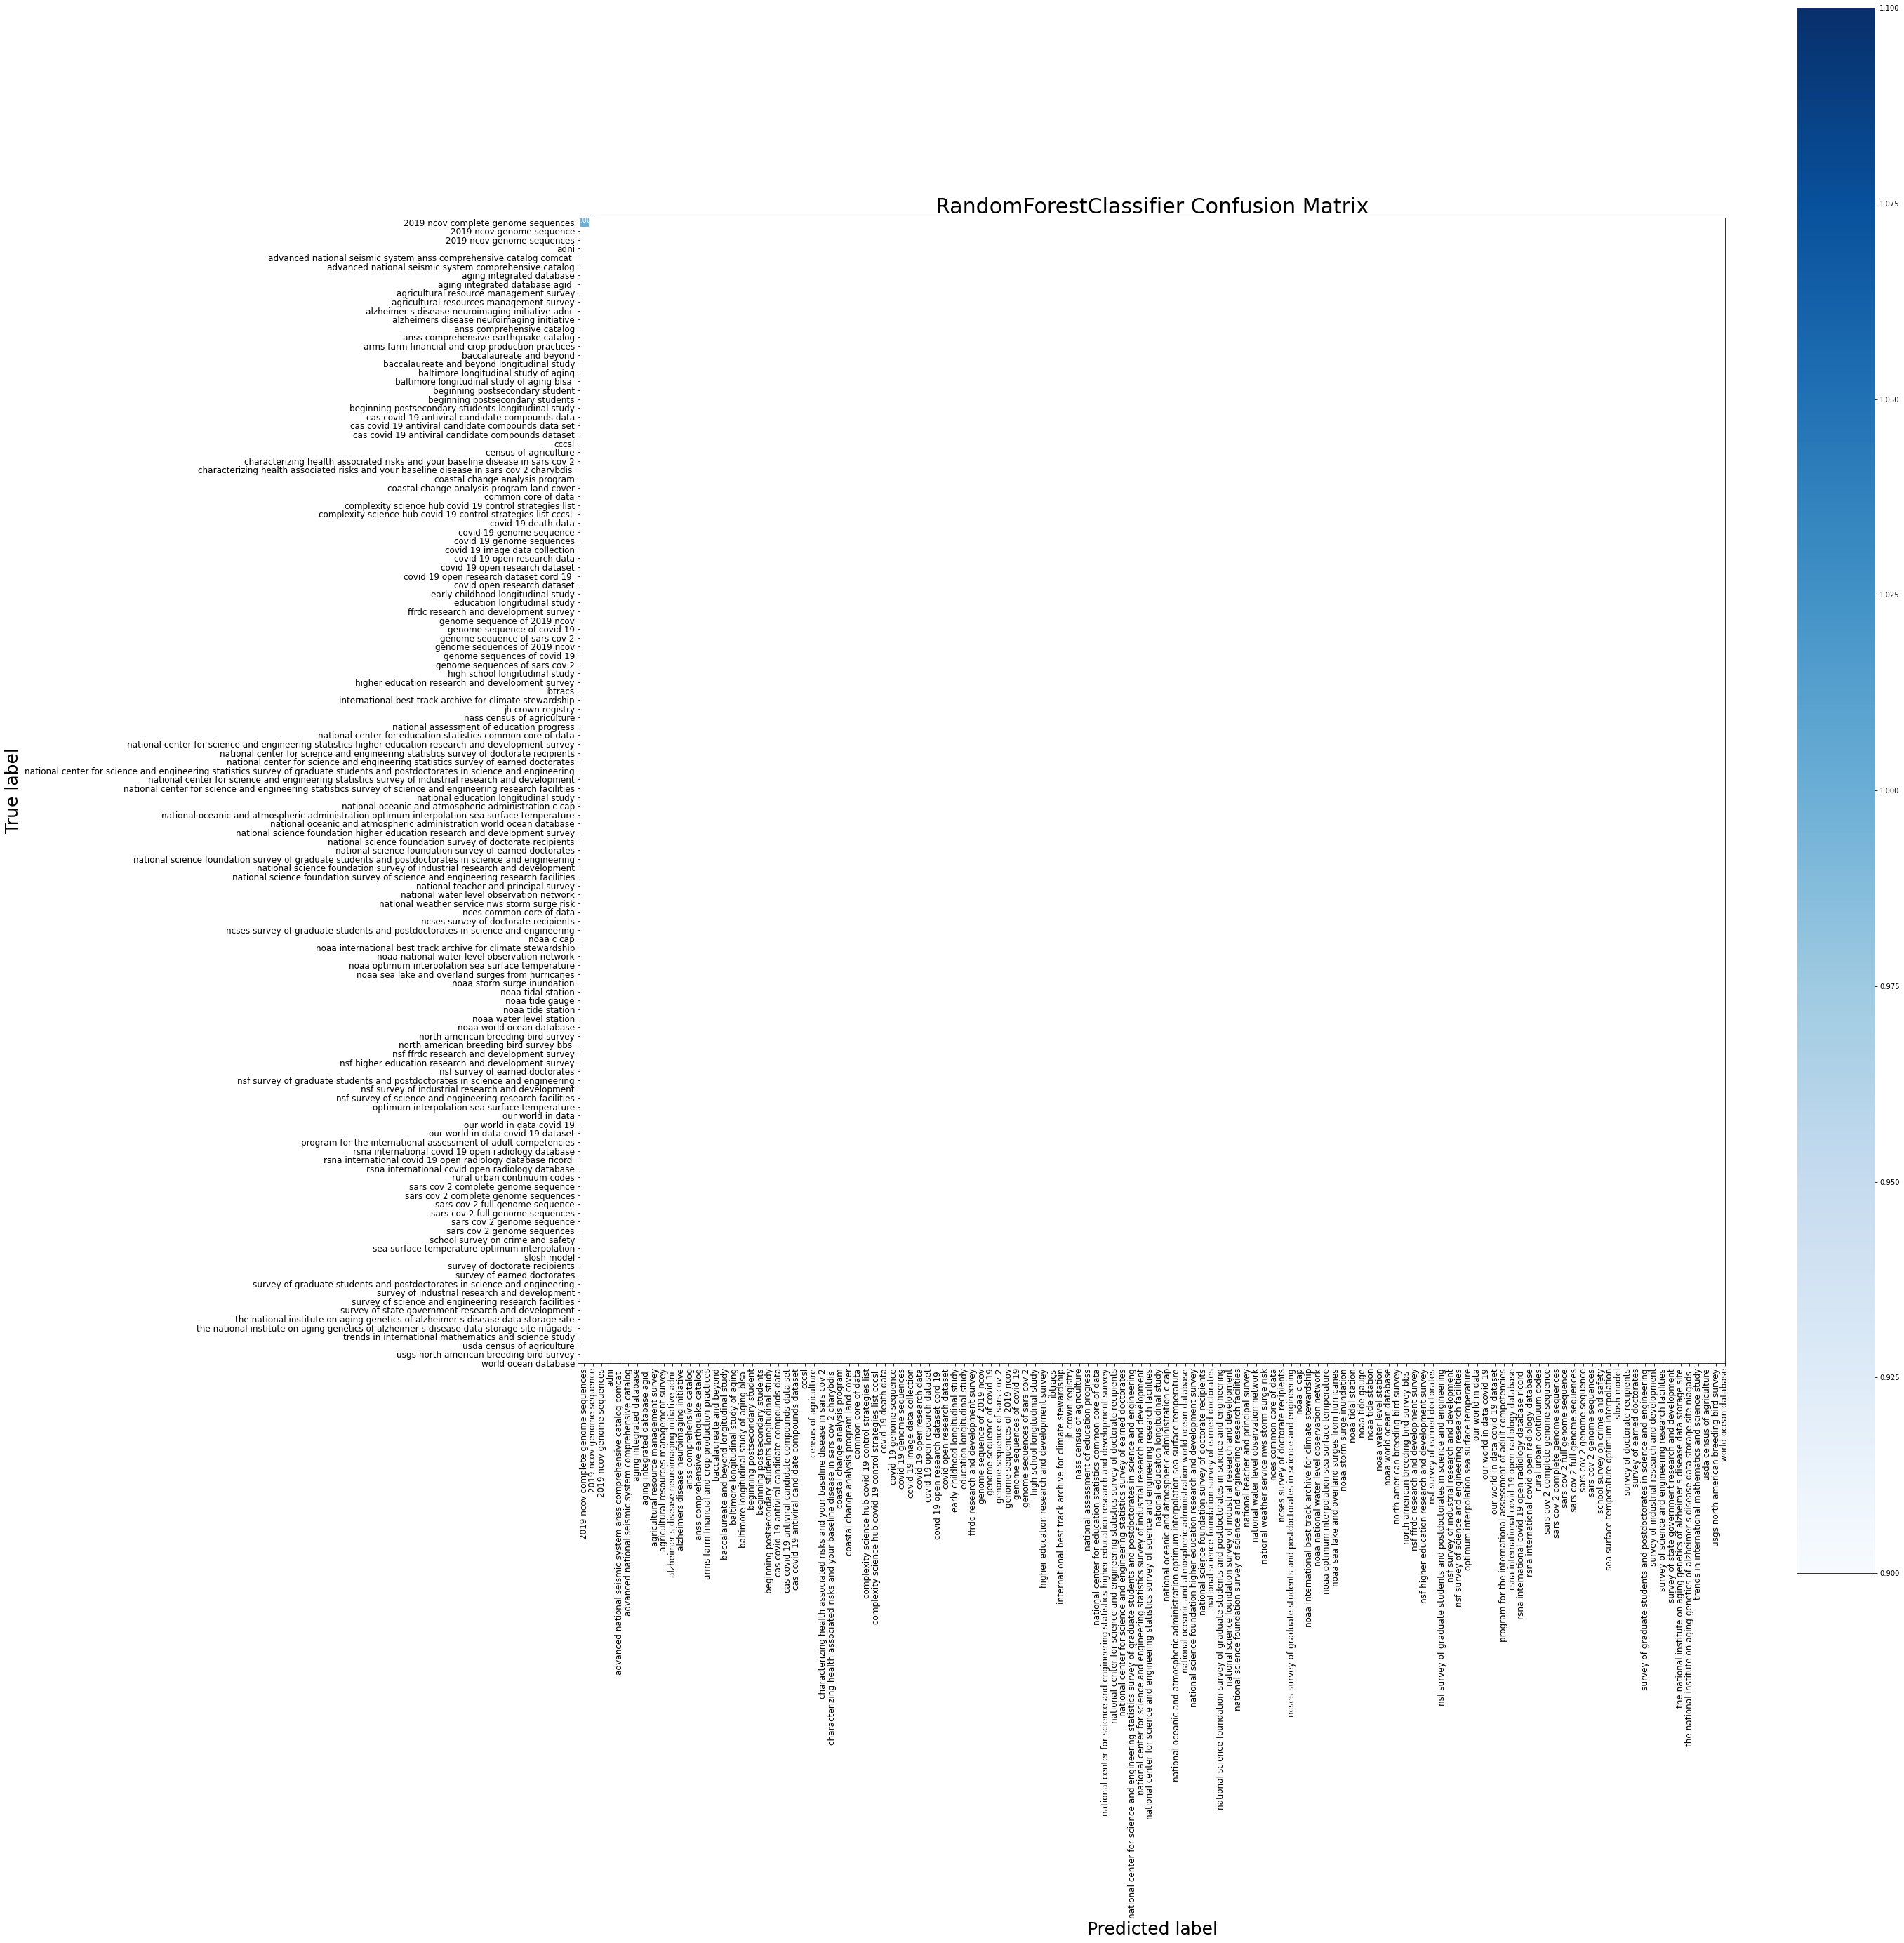

<Figure size 432x288 with 0 Axes>

In [28]:
#get confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize = (40, 40))
plot_confusion_matrix(cm, classes = text_labels, title = 'RandomForestClassifier Confusion Matrix')
plt.show()

#save
plt.savefig('RandomForestClassifier_cm.png')

In [29]:
#summary table
summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [],
                              'CV': [],
                              'Precision': [], 'Recall': [], 'F1': []})

In [30]:
summary_table.loc[0] = ['CLF RandomForestClassifier',
                        round(accuracy_score(y_test, RandomForestClassifier_yhat_test), 2),
                        round(RandomForestClassifier_CV, 2),
                        round(precision_score(y_test, RandomForestClassifier_yhat_test, average = 'macro'), 2), 
                        round(recall_score(y_test, RandomForestClassifier_yhat_test, average = 'macro'), 2), 
                        round(f1_score(y_test, RandomForestClassifier_yhat_test, average = 'macro'), 2)]
summary_table.head()

Model  Accuracy    CV  Precision  Recall    F1
0  CLF RandomForestClassifier      0.75  0.75       0.31    0.37  0.33

## Linear Support Vector Machine

In [31]:
from sklearn.linear_model import SGDClassifier

#create a tokenization a modelling pipeline
SGDClassifier_model = Pipeline([('tfidf', TfidfVectorizer(min_df = 3,
                                                max_features = None,
                                                strip_accents = 'unicode',
                                                analyzer = 'word',
                                                token_pattern = r'\w{1,}',
                                                ngram_range = (1, 3),
                                                use_idf = 1,
                                                smooth_idf = 1,
                                                sublinear_tf = 1,
                                                stop_words = stopwords_list)), #convert words to munbers using tfid
                                ('clf', SGDClassifier(loss = 'hinge', #use Linear SVC(SVM) model when the parameter loss is set to 'hinge'
                                                      penalty = 'l2',
                                                      alpha = 1e-3,
                                                      random_state = 123,
                                                      max_iter = 5))]) #model the text

#fit the pipeline to the training data
SGDClassifier_model.fit(X_train, y_train) 

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode', sublinear_tf=1,
                                 token_pattern='\\w{1,}', use_idf=1)),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=123))])

In [32]:
#predict 
SGDClassifier_yhat_train = SGDClassifier_model.predict(X_train)
SGDClassifier_yhat_test = SGDClassifier_model.predict(X_test)

#train accuracy 
SGDClassifier_train_accuracy = accuracy_score(y_train, SGDClassifier_yhat_train) * 100
print('Train accuracy: {0}'.format(SGDClassifier_train_accuracy))

#test accuracy 
SGDClassifier_test_accuracy = accuracy_score(y_test, SGDClassifier_yhat_test) * 100
print('Test accuracy: {0}'.format(SGDClassifier_test_accuracy))

Train accuracy: 74.42777212614445
Test accuracy: 74.42156114924994


In [33]:
#get cross validation
SGDClassifier_CV = cross_val_score(SGDClassifier_model, X_train, y_train,
                                   cv = k_fold, scoring = 'accuracy', n_jobs=-1).mean()
SGDClassifier_CV

0.7402084459838469

In [34]:
#get classification report
print('Model: Support Vector Machine', '\n', classification_report(y_test, SGDClassifier_yhat_test))

Model: Support Vector Machine 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.58      1.00      0.74       709
           4       0.00      0.00      0.00         2
           8       0.94      1.00      0.97       127
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00       487
          11       0.00      0.00      0.00        17
          12       0.40      1.00      0.57         2
          13       0.00      0.00      0.00         1
          15       0.68      1.00      0.81        45
          16       0.00      0.00      0.00        21
          17       0.74      1.00      0.85       248
          18       0.00      0.00      0.00        86
          19       0.00      0.00      0.00        13
          20       0.47      1.00      0.64        47
          21       0.00      0.00      0.00      

In [35]:
#generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(5):
    prediction = SGDClassifier_model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences



In [36]:
y_softmax = SGDClassifier_model.predict(X_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

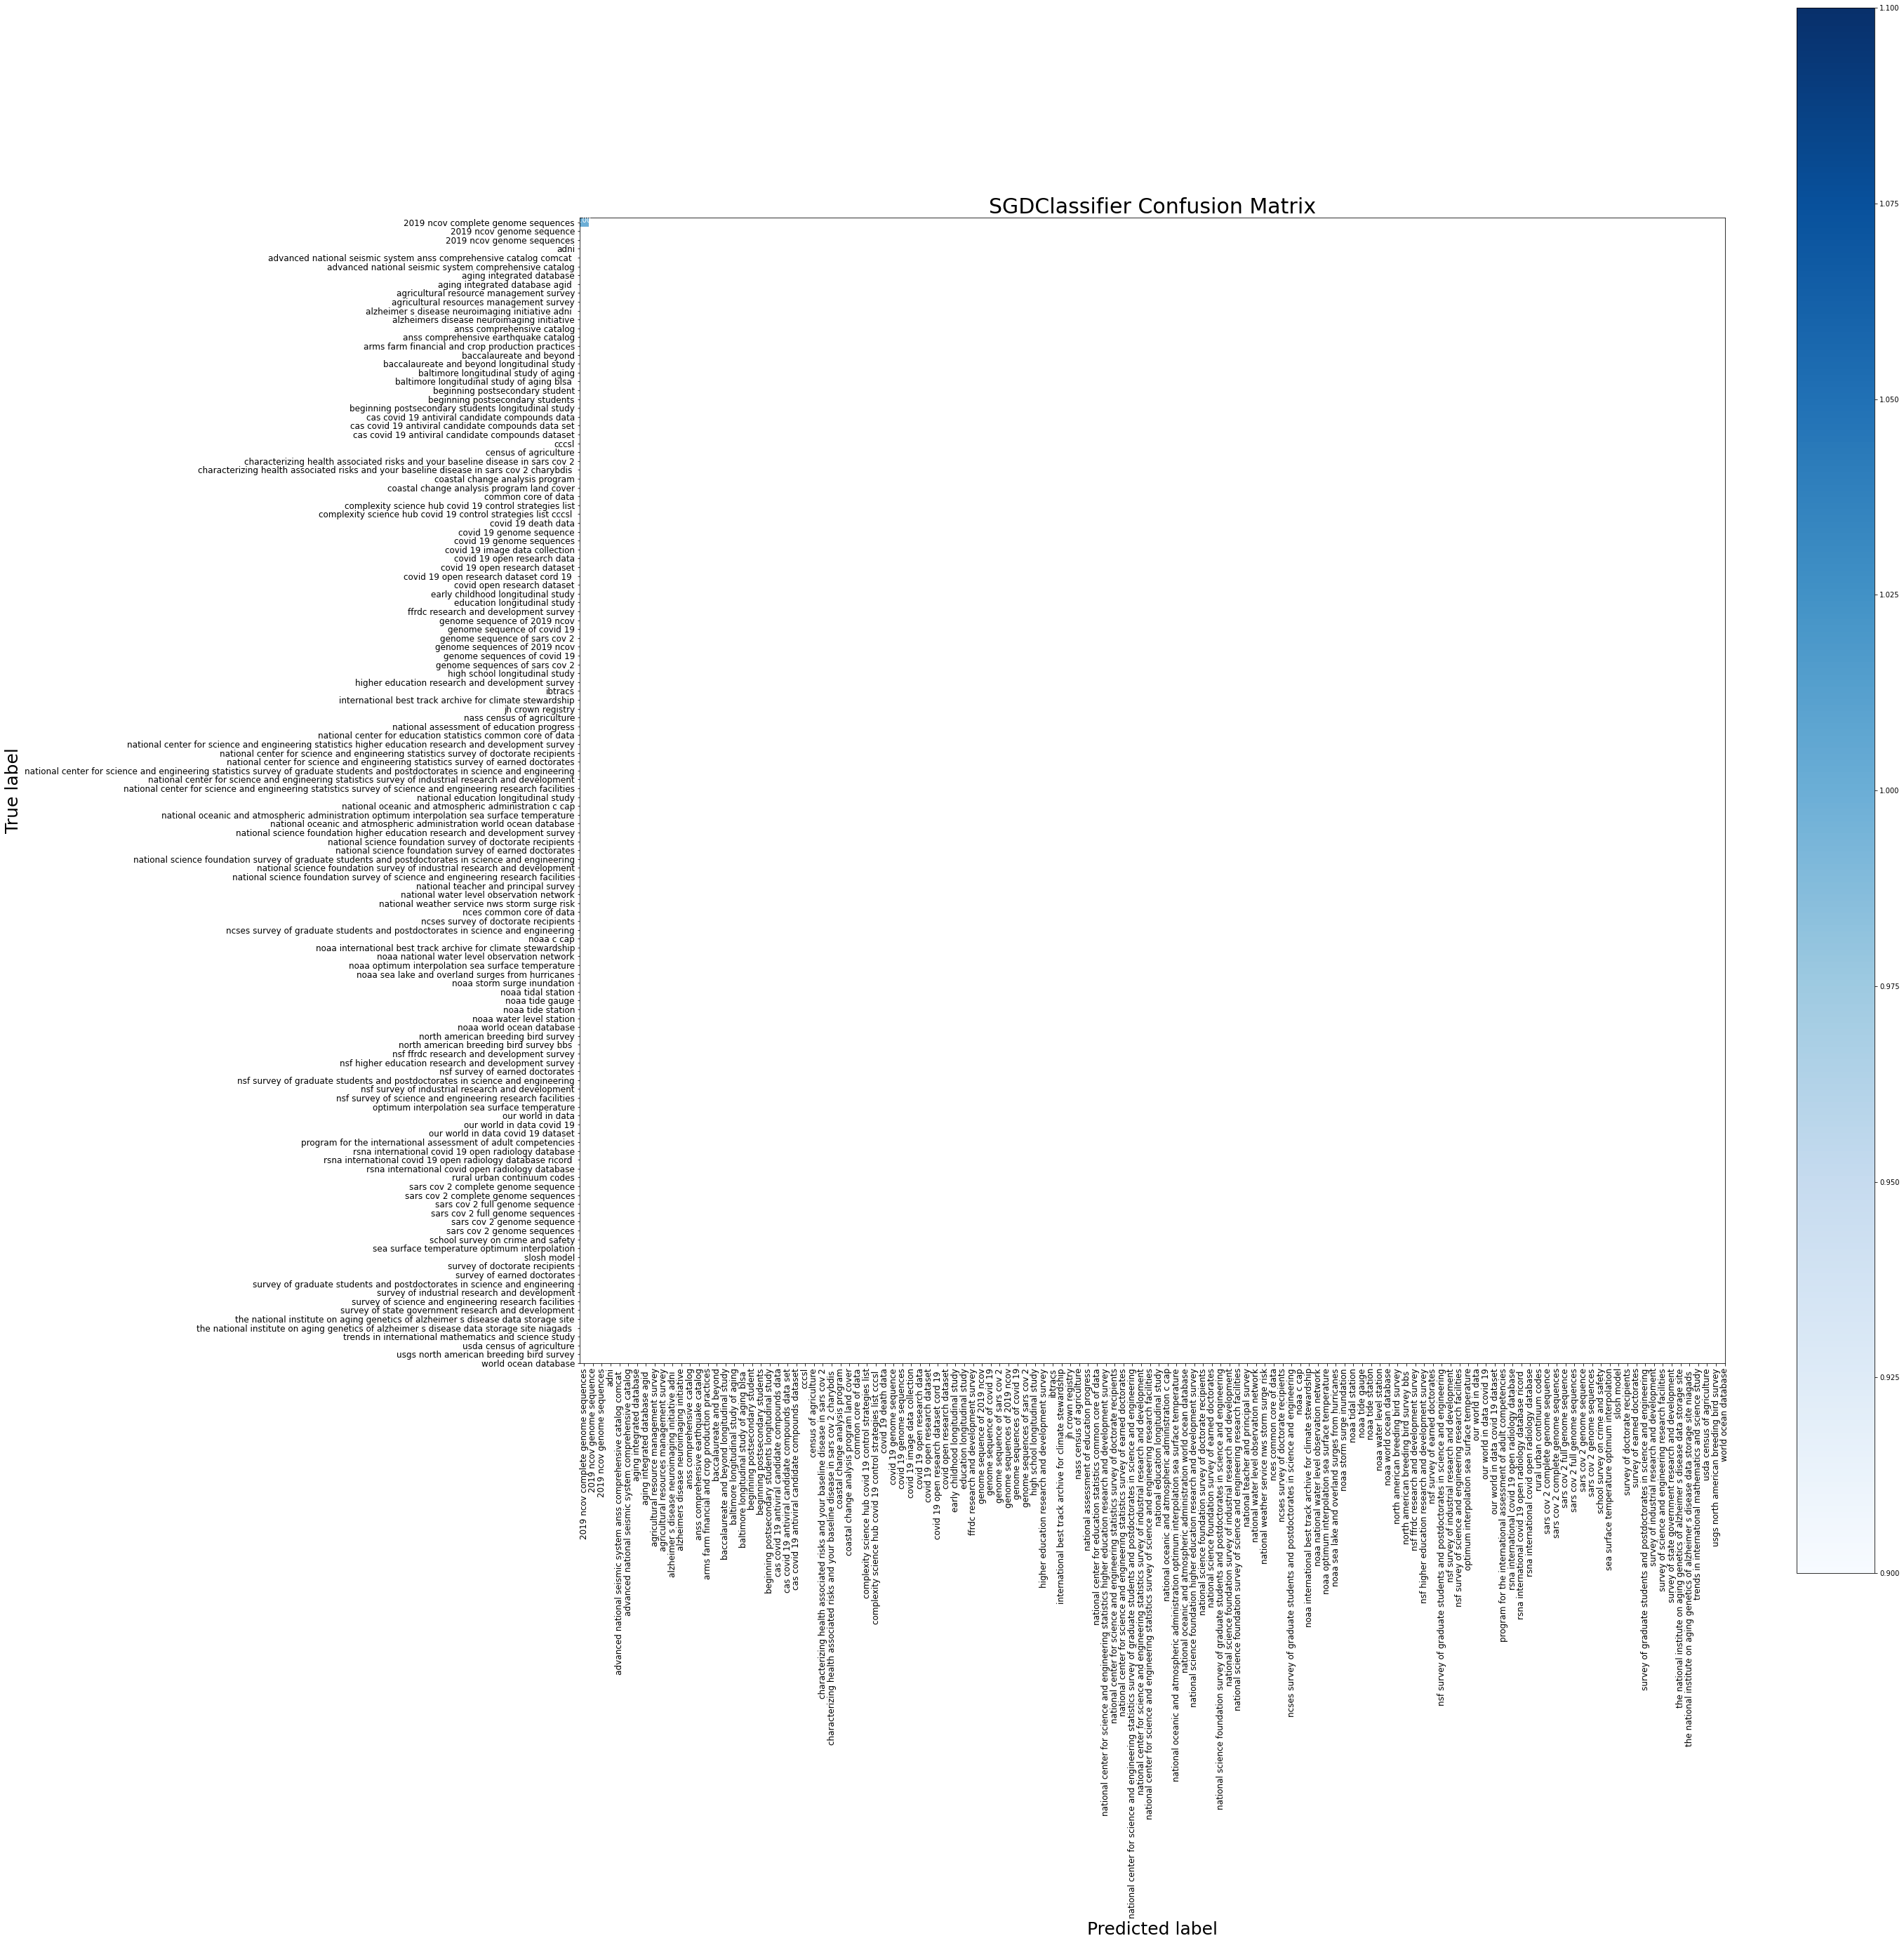

<Figure size 432x288 with 0 Axes>

In [37]:
#get confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize = (40, 40))
plot_confusion_matrix(cm, classes = text_labels, title = 'SGDClassifier Confusion Matrix')
plt.show()

#save
plt.savefig('SGDClassifier_cm.png')

In [38]:
summary_table.loc[1] = ['CLF Linear Support Vector Machine',
                        round(accuracy_score(y_test, SGDClassifier_yhat_test), 2),
                        round(SGDClassifier_CV, 2),
                        round(precision_score(y_test, SGDClassifier_yhat_test, average = 'macro'), 2), 
                        round(recall_score(y_test, SGDClassifier_yhat_test, average = 'macro'), 2), 
                        round(f1_score(y_test, SGDClassifier_yhat_test, average = 'macro'), 2)]
summary_table.head()

Model  Accuracy    CV  Precision  Recall    F1
0         CLF RandomForestClassifier      0.75  0.75       0.31    0.37  0.33
1  CLF Linear Support Vector Machine      0.74  0.74       0.30    0.36  0.33

# Naive Bayes MultinomialNB

In [39]:
from sklearn.naive_bayes import MultinomialNB

#create a tokenization a modelling pipeline
MultinomialNB_model = Pipeline([('tfidf', TfidfVectorizer(min_df = 3,  
                                                          max_features = None,
                                                          strip_accents = 'unicode', 
                                                          analyzer = 'word',
                                                          token_pattern = r'\w{1,}',
                                                          ngram_range = (1, 3), 
                                                          use_idf = 1,
                                                          smooth_idf = 1,
                                                          sublinear_tf = 1,
                                                          stop_words = stopwords_list)), #convert words to munbers using tfid
                                ('clf', MultinomialNB())]) #model the text

#fit the pipeline to the training data
MultinomialNB_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode', sublinear_tf=1,
                                 token_pattern='\\w{1,}', use_idf=1)),
                ('clf', MultinomialNB())])

In [40]:
#predict 
MultinomialNB_yhat_train = MultinomialNB_model.predict(X_train)
MultinomialNB_yhat_test = MultinomialNB_model.predict(X_test)

#train accuracy 
MultinomialNB_train_accuracy = accuracy_score(y_train, MultinomialNB_yhat_train) * 100
print('Train accuracy: {0}'.format(MultinomialNB_train_accuracy))

#test accuracy 
MultinomialNB_test_accuracy = accuracy_score(y_test, MultinomialNB_yhat_test) * 100
print('Test accuracy: {0}'.format(MultinomialNB_test_accuracy))

Train accuracy: 74.49771108850459
Test accuracy: 74.5486905669972


In [41]:
#get cross validation
MultinomialNB_CV = cross_val_score(MultinomialNB_model, X_train, y_train,
                                   cv = k_fold, scoring = 'accuracy', n_jobs=-1).mean()
MultinomialNB_CV

0.7444050183087617

In [42]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

#get classification report
print('Model: MultinomialNB', '\n', classification_report(y_test, MultinomialNB_yhat_test))

Model: MultinomialNB 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.58      1.00      0.74       709
           4       0.00      0.00      0.00         2
           8       0.94      1.00      0.97       127
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00       487
          11       0.00      0.00      0.00        17
          12       0.40      1.00      0.57         2
          13       0.00      0.00      0.00         1
          15       0.68      1.00      0.81        45
          16       0.00      0.00      0.00        21
          17       0.74      1.00      0.85       248
          18       0.00      0.00      0.00        86
          19       0.00      0.00      0.00        13
          20       0.47      1.00      0.64        47
          21       0.00      0.00      0.00        39
    

In [43]:
#generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(5):
    prediction = MultinomialNB_model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: 2019 ncov complete genome sequences



In [44]:
y_softmax = MultinomialNB_model.predict(X_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

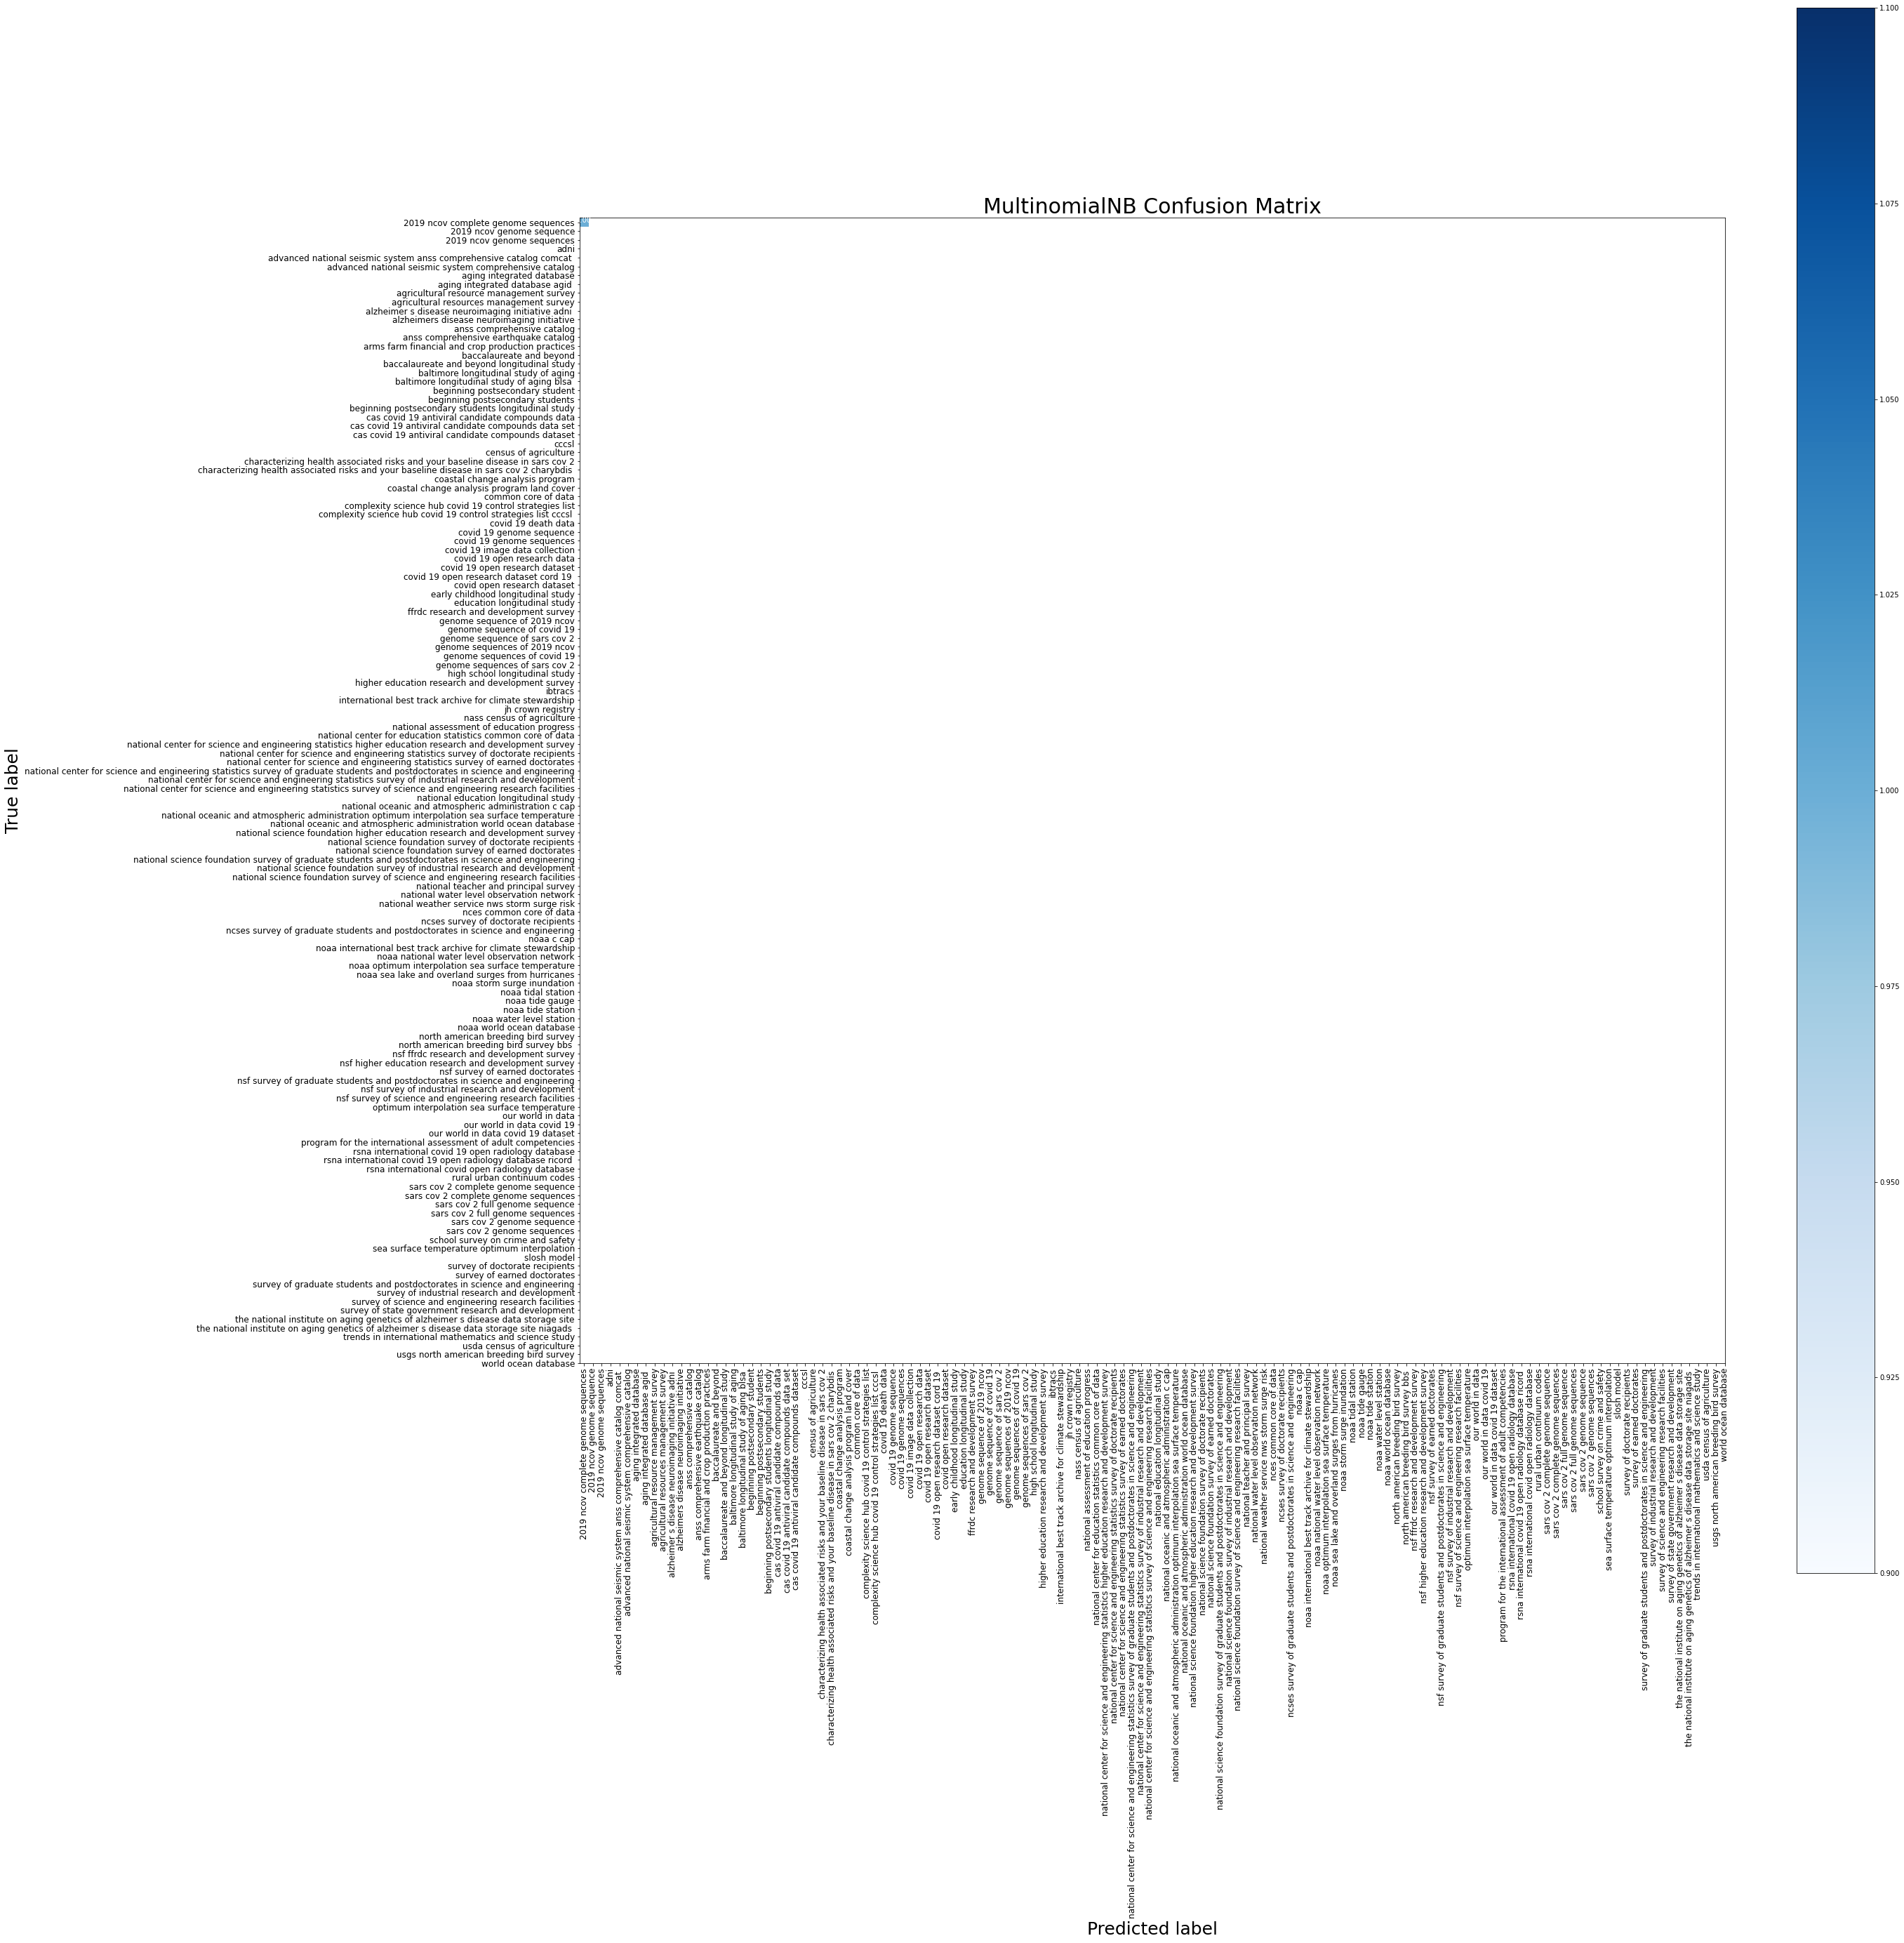

<Figure size 432x288 with 0 Axes>

In [45]:
#get confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize = (40, 40))
plot_confusion_matrix(cm, classes = text_labels, title = 'MultinomialNB Confusion Matrix')
plt.show()

#save
plt.savefig('MultinomialNB_cm.png')

In [46]:
#update summary table
summary_table.loc[2] = ['CLF MultinomialNB',
                        round(accuracy_score(y_test, MultinomialNB_yhat_test), 2),
                        round(MultinomialNB_CV, 2),
                        round(precision_score(y_test, MultinomialNB_yhat_test, average = 'macro'), 2), 
                        round(recall_score(y_test, MultinomialNB_yhat_test, average = 'macro'), 2), 
                        round(f1_score(y_test, MultinomialNB_yhat_test, average = 'macro'), 2)]
summary_table.head()

Model  Accuracy    CV  Precision  Recall    F1
0         CLF RandomForestClassifier      0.75  0.75       0.31    0.37  0.33
1  CLF Linear Support Vector Machine      0.74  0.74       0.30    0.36  0.33
2                  CLF MultinomialNB      0.75  0.74       0.30    0.37  0.33

In [47]:
#save
summary_table.to_csv('clf_summary_table.csv')

# INTERPRETATION